In [71]:
import numpy as np
#import pandas as pd
import modin.pandas as pd
import ray
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
%matplotlib inline


In [30]:
tf.random.set_seed(7)
def load_data(filename):
    df = pd.read_csv(filename, parse_dates=['Date'], index_col='Date')
    df = df.sort_index()
    return df

In [ ]:
def explore_data(df, target_col='Adj Close', date_col='Date'):
    df_analysis = df.copy()
    print(f"Shape of dataset: {df_analysis.shape}")
    print(f"Missing vals in each column:\n {df_analysis.isnull().sum()}")
    print(f"Date range: {df_analysis.index.min()} to {df_analysis.index.max()}")

    print(df_analysis.head())
    print(df_analysis.info())
    print(df_analysis.describe())

    fig, axes = plt.subplots(1, 3, figsize=(24, 8))
    fig.suptitle('Stock Price Time Series Analysis', fontsize=16, y=1.02)
    axes[0] = sns.lineplot(data=df_analysis, x=df_analysis.index, y='Adj Close', ax=axes[0])
    axes[0].set_title('Adjusted Close Price Over Time')
    axes[0].set_xlabel('Date')
    axes[0].set_ylabel('Adjusted Close Price')

    price_cols = ['High', 'Low', 'Open', 'Close']
    for col in price_cols:
        axes[1].plot(df_analysis.index, df_analysis[col], alpha=0.6, label=col)
    axes[1].set_title('All Price Features Over Time')
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel('Price')
    axes[1].legend(loc='best')
    axes[1].grid(True, alpha=0.3)

    rolling_mean = df_analysis['Adj Close'].rolling(window=30).mean()
    rolling_std = df_analysis['Adj Close'].rolling(window=30).std()
    
    axes[2].plot(df_analysis.index, df_analysis['Adj Close'], label='Original', alpha=0.5, linewidth=1)
    axes[2].plot(df_analysis.index, rolling_mean, label='30-day Rolling Mean', color='red', linewidth=2)
    axes[2].fill_between(df_analysis.index, rolling_mean - 2*rolling_std,
    rolling_mean + 2*rolling_std, color='red', alpha=0.1)

    axes[2].set_title(' Adj Closing Price with 30-day Rolling Mean & ±2 Bands')
    axes[2].set_xlabel('Date')
    axes[2].set_ylabel('Adj Close Price')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


    correlation_matrix = df_analysis[['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close']].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", xticklabels=correlation_matrix.columns, yticklabels=correlation_matrix.columns)
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.show()

    scatter_features = ['Open', 'High', 'Low', 'Close', 'Volume','Adj Close']
    pd.plotting.scatter_matrix(df_analysis[scatter_features], alpha=0.2, diagonal='kde', figsize=(12,12))
    plt.title('Scatter Matrix of Selected Features')
    plt.tight_layout()
    plt.show()

    try:
        adj_close_series = df_analysis['Adj Close'].dropna()
        period = 60
        decomposition = seasonal_decompose(adj_close_series, model='additive', period=period, extrapolate_trend='freq')
        fig, axes = plt.subplots(4, 1, figsize=(15, 12))
        fig.suptitle(f'Seasonal Decomposition (Period={period} days)', fontsize=14, y=1.02)
        plot_dates = adj_close_series.index[period-1:]
        axes[0].plot(plot_dates, decomposition.observed[period-1:], color='blue', linewidth=1)
        axes[0].set_title('Observed')
        axes[0].grid(True, alpha=0.3)
        axes[1].plot(plot_dates, decomposition.trend[period-1:], color='green', linewidth=1)
        axes[1].set_title('Trend')
        axes[1].grid(True, alpha=0.3)
        axes[2].plot(plot_dates, decomposition.seasonal[period-1:], color='orange', linewidth=1)
        axes[2].set_title('Seasonal')
        axes[2].grid(True, alpha=0.3)
        axes[3].plot(plot_dates, decomposition.resid[period-1:], color='red', linewidth=1)
        axes[3].set_title('Residual')
        axes[3].grid(True, alpha=0.3)
        axes[3].axhline(0, linestyle='--', color='black', linewidth=1)
        plt.tight_layout()
        plt.show()

        seasonal_std = decomposition.seasonal.std()
        trend_std = decomposition.trend.std()
        print(f"Seasonality Std Dev: {seasonal_std:.4f}")
        print(f"Trend Std Dev: {trend_std:.4f}")
        print(f"Seasonality/Trend ratio: {seasonal_std/trend_std:.4f}")
    except Exception as e:
        print(f"Seasonal decomposition warning: {e}")
        print("Trying with different period...")

def init_data_prep(df,features,Seq,target_idx=5):
    data = df[features].values
    scaler = MinMaxScaler(feature_range=(0,1))
    data_scaled = scaler.fit_transform(data)
    X, y = [], []
    for i in range(Seq, len(data_scaled)):
        X.append(data_scaled[i-Seq:i])
        y.append(data_scaled[i, target_idx])
    X, y = np.array(X), np.array(y)

    train_size = int(0.8*len(X))
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    print(f"Training data shape: {X_train.shape}")
    print(f"Testing data shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test, scaler, features, train_size

def lstm_model(units, Dpr, input_shape):
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    loss = 'mean_squared_error'
    metrics = ['mae']
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=input_shape)),BatchNormalization()
    model.add(LSTM(units=units, return_sequences=True, input_shape=input_shape)), LayerNormalization()
    model.add(LSTM(units=units, return_sequences=False, input_shape=input_shape))
    model.add(Dropout(Dpr))
    model.add(Dense(units=1))
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    model.summary()
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)
    ]
    return model, callbacks

def model_train(model, callbacks, X_train, y_train, X_test, y_test, epochs, batch_size):
    history = model.fit(
        X_train, y_train,
        validation_data = (X_test, y_test),
        epochs = epochs,
        batch_size = batch_size,
        callbacks = callbacks,
        verbose = 1
    )

    fig, axes = plt.subplots(1,2, figsize=(14,5))
    axes[0].plot(history.history['loss'], label='Training Loss')
    axes[0].plot(history.history['val_loss'], label='validation loss')
    axes[0].set_title('Training Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    axes[1].plot(history.history['mae'], label='training mae')
    axes[1].plot(history.history['val_mae'], label='validation mae')
    axes[1].set_title('Model MAE')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('MAE')
    axes[1].legend()
    plt.show()
    return model

def model_eval(model, df, train_size, Seq, X_test, y_test, scaler, target_idx=5):
    y_pred = model.predict(X_test)

    y_pred_reshaped = np.zeros((len(y_pred), 6))
    y_test_reshaped = np.zeros((len(y_test), 6))
    y_pred_reshaped[:, target_idx] = y_pred.flatten()
    y_test_reshaped[:, target_idx] = y_test
    y_pred_inverted = scaler.inverse_transform(y_pred_reshaped)[:, target_idx]
    y_test_inverted = scaler.inverse_transform(y_test_reshaped)[:, target_idx]

    mse = mean_squared_error(y_test_inverted, y_pred_inverted)
    rsme = np.sqrt(mse)
    mae = mean_absolute_error(y_test_inverted, y_pred_inverted)
    r2 = r2_score(y_test_inverted, y_pred_inverted)
    print(f"Mean squared error: {mse:.4f}")
    print(f"Root Mean Squared Error: {rsme:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"r2 Score: {r2:.4f}")

    plt.figure(figsize=(12,6))
    plt.plot(y_test_inverted, color='blue', label='Actual Stock Price', alpha=0.7)
    plt.plot(y_pred_inverted, color='green', label='Predicted Stock Price', alpha=0.7)
    plt.title('Actual vs Predicted Stock Price')
    plt.xlabel('Time Steps')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

    test_dates = df.index[train_size + Seq:]
    plt.figure(figsize=(12,6))
    plt.plot(test_dates, y_test_inverted, label='Actual Close Price', linewidth=2)
    plt.plot(test_dates, y_pred_inverted, label='Predicted Close Price', linewidth=2, alpha=0.8)
    plt.title('Stock Price Prediction: Actual vs Predicted (With Dates)', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Close Price', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [32]:
ray.init(ignore_reinit_error=True)

2026-01-31 15:06:09,120	INFO worker.py:1839 -- Calling ray.init() again after it has already been called.


Python version:,3.12.12
Ray version:,2.53.0


In [33]:
stocks_df = load_data('yahoo_stock.csv')

Shape of dataset: (1825, 6)
Missing vals in each column:
 High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64
Date range: 2015-11-23 00:00:00 to 2020-11-20 00:00:00
                   High          Low         Open        Close        Volume  \
Date                                                                           
2015-11-23  2095.610107  2081.389893  2089.409912  2086.590088  3.587980e+09   
2015-11-24  2094.120117  2070.290039  2084.419922  2089.139893  3.884930e+09   
2015-11-25  2093.000000  2086.300049  2089.300049  2088.870117  2.852940e+09   
2015-11-26  2093.000000  2086.300049  2089.300049  2088.870117  2.852940e+09   
2015-11-27  2093.290039  2084.129883  2088.820068  2090.110107  1.466840e+09   

              Adj Close  
Date                     
2015-11-23  2086.590088  
2015-11-24  2089.139893  
2015-11-25  2088.870117  
2015-11-26  2088.870117  
2015-11-27  2090.110107  
<class 'modin.pandas.dataframe.DataFrame'

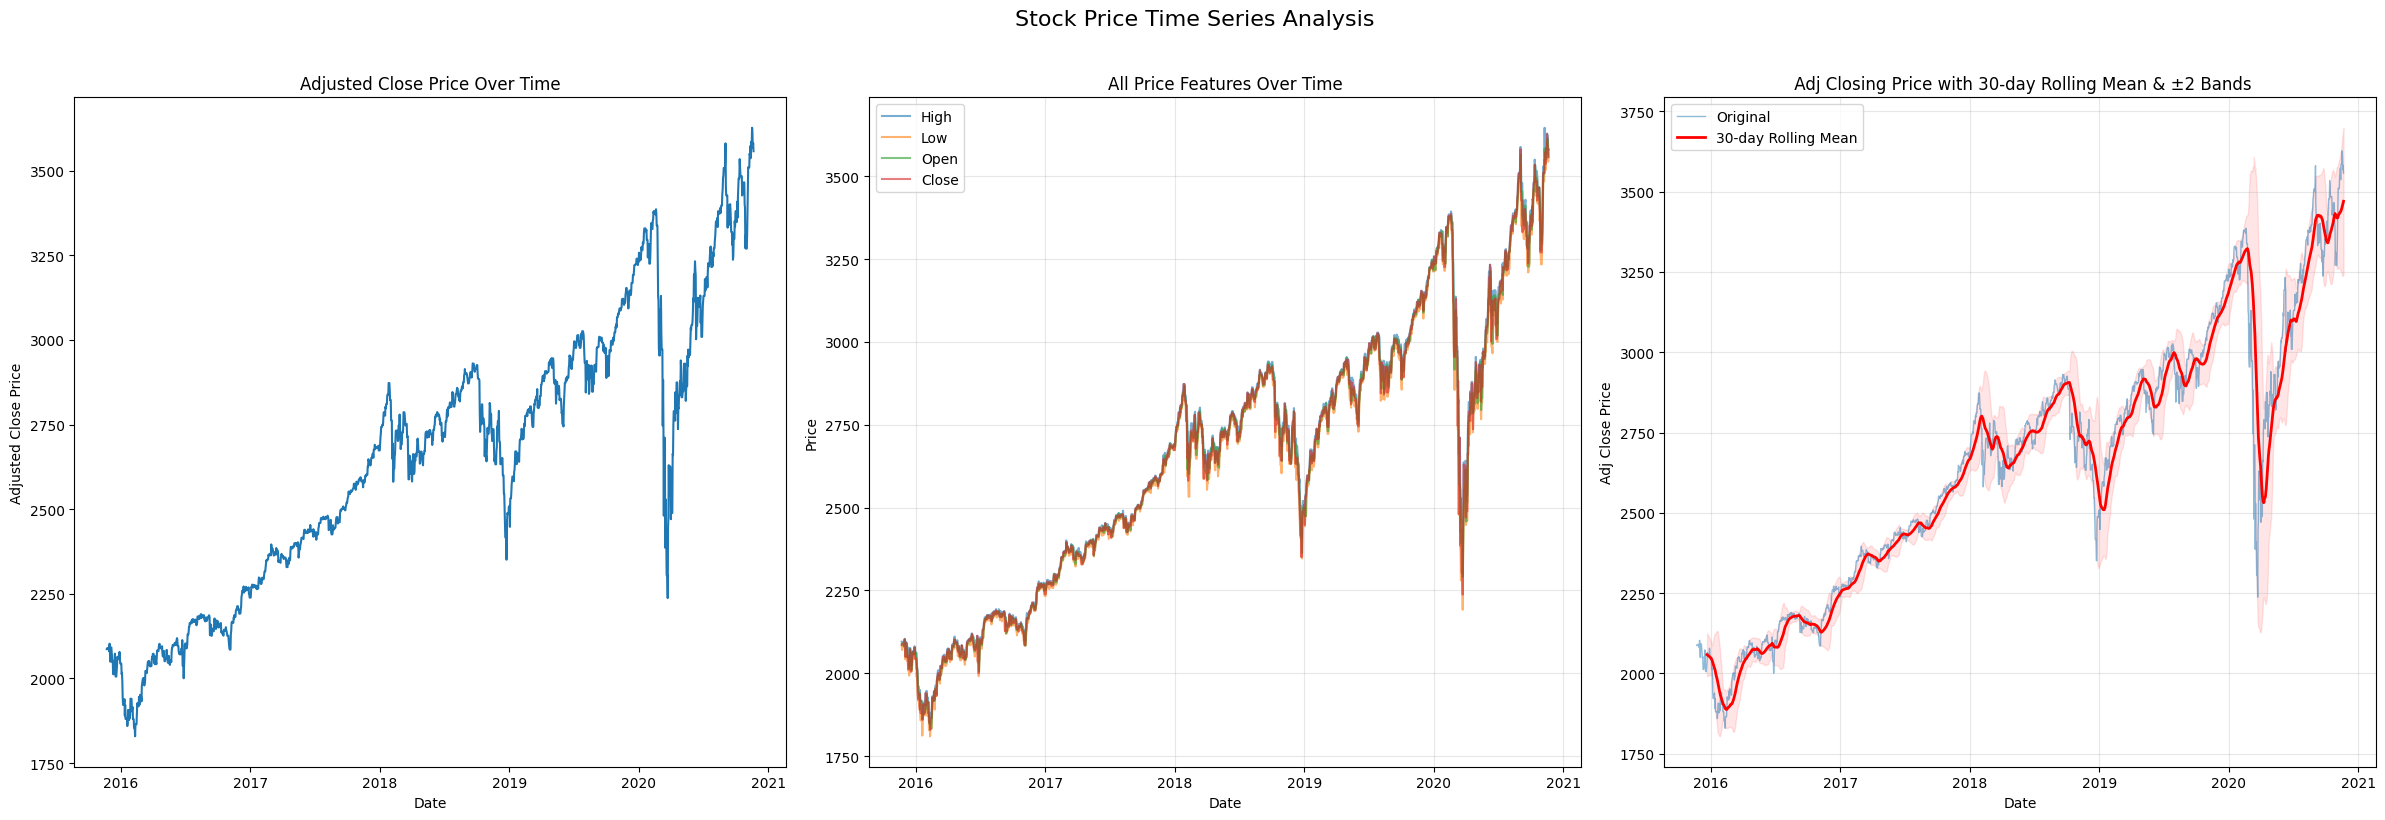

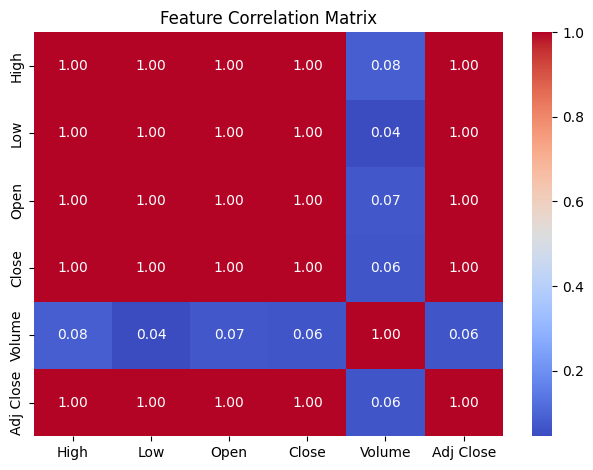

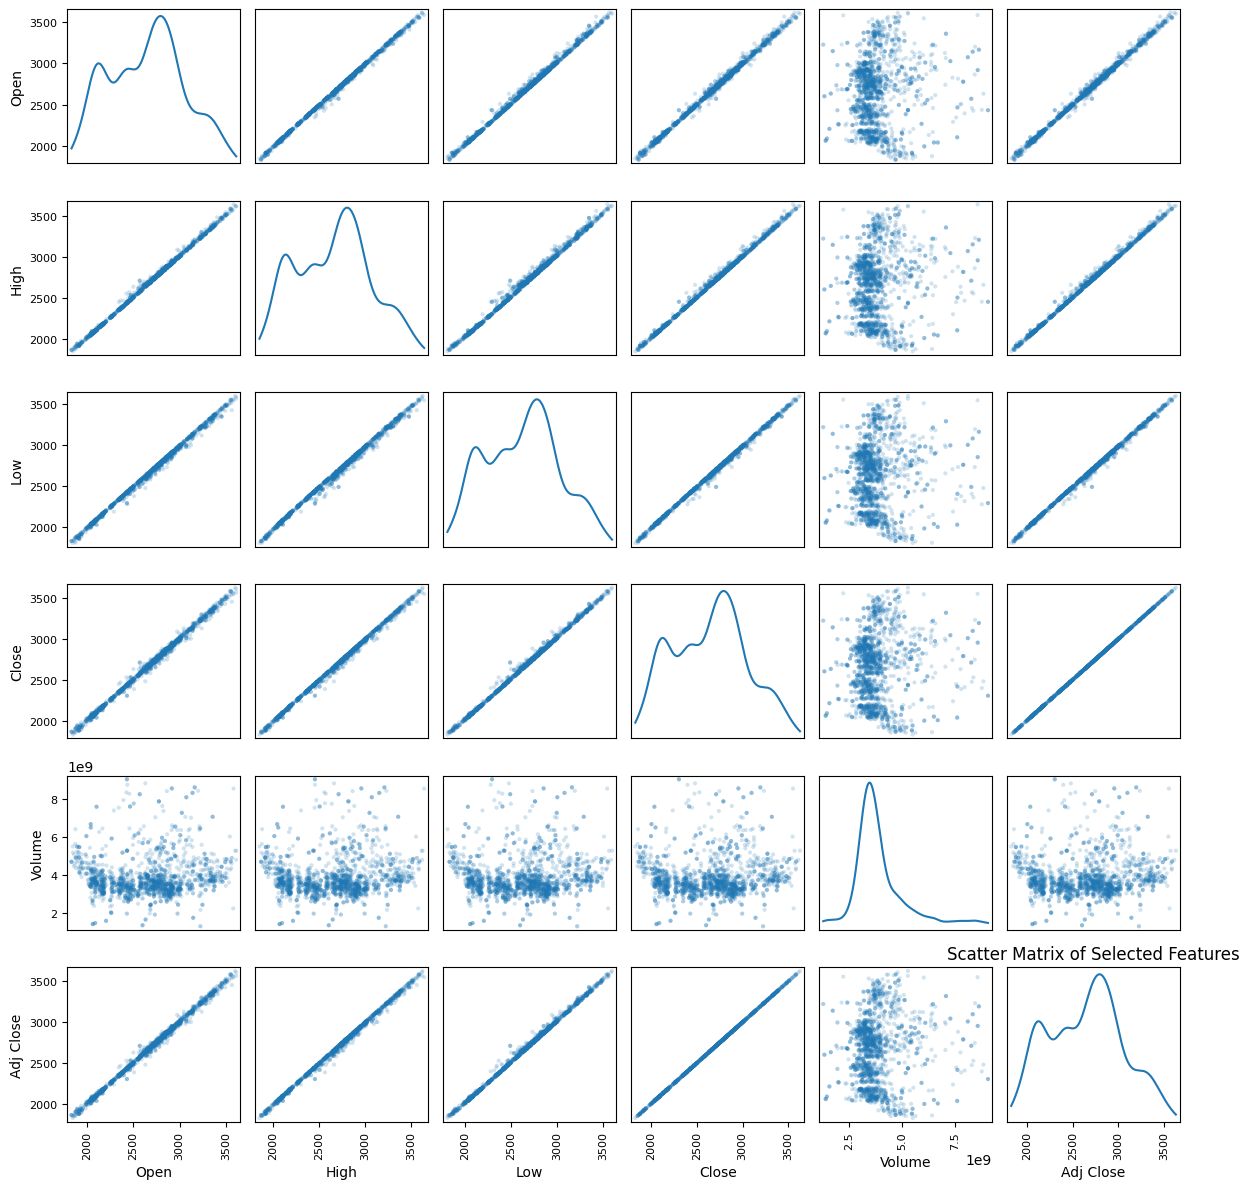

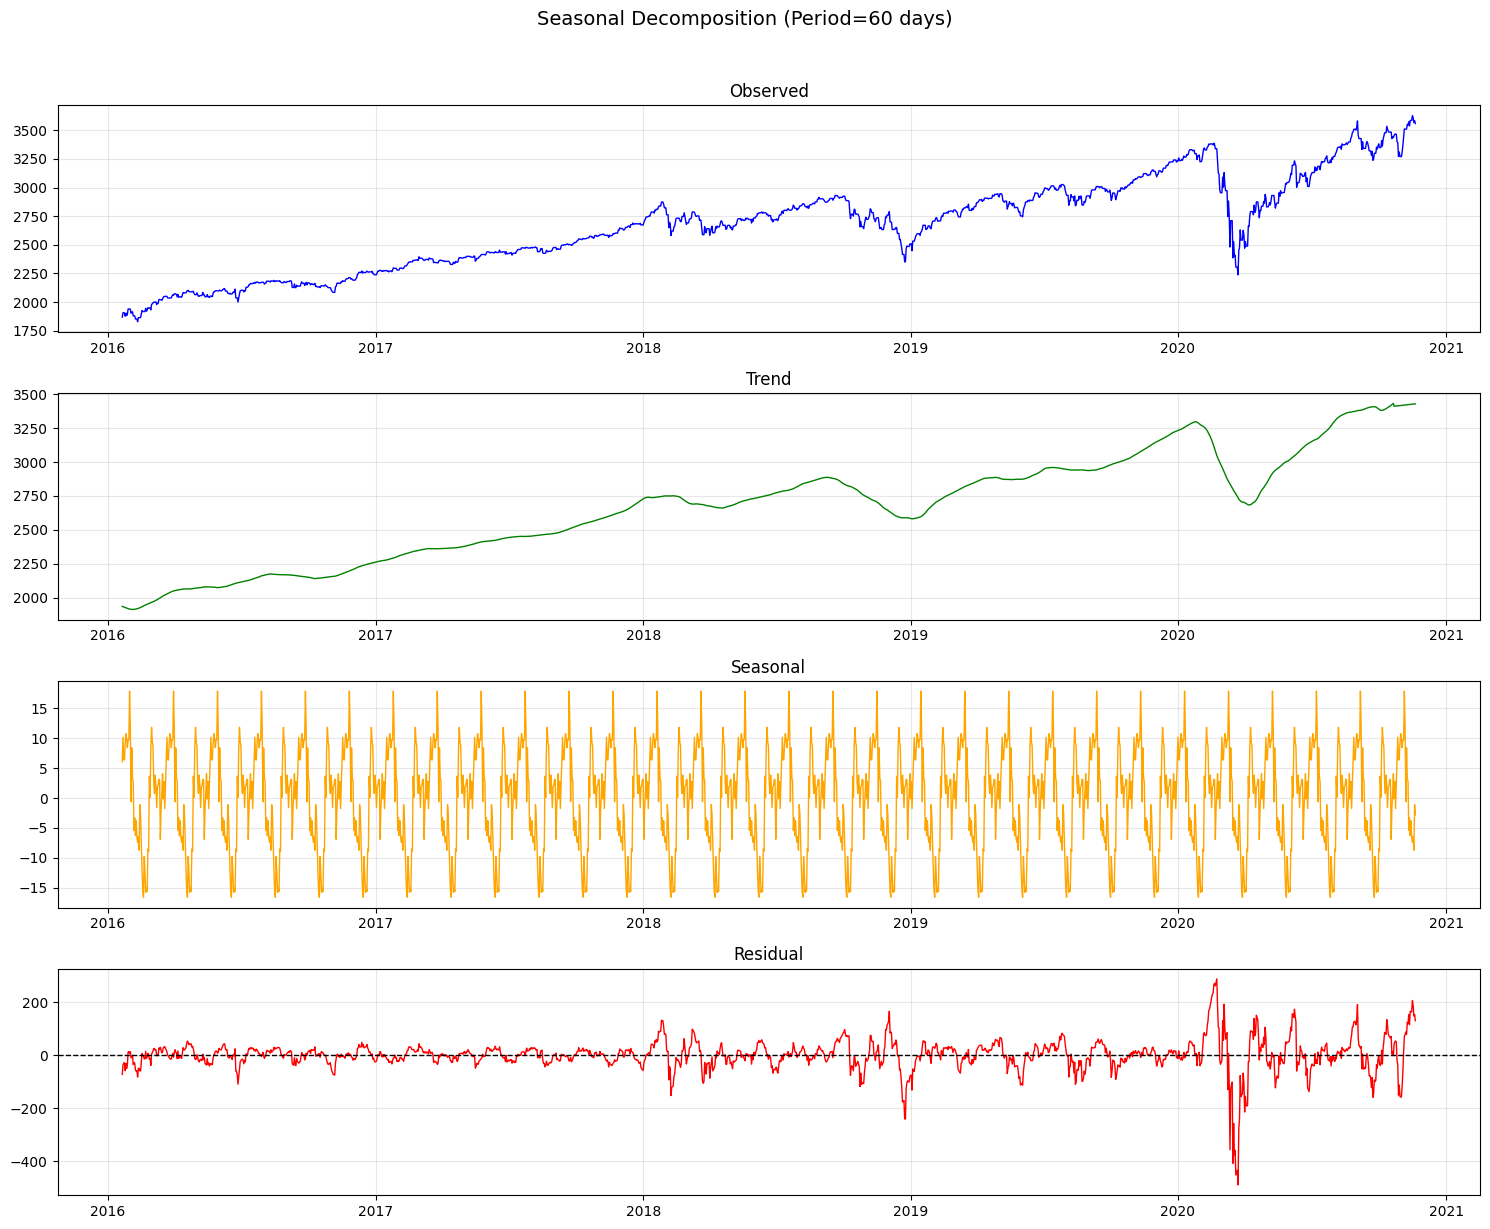

Seasonality Std Dev: 8.1797
Trend Std Dev: 398.2776
Seasonality/Trend ratio: 0.0205


In [93]:
explore_data(stocks_df)

In [34]:
X_train, X_test, y_train, y_test, scaler, features, train_size = init_data_prep(stocks_df, ['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close'], Seq=60)

Training data shape: (1412, 60, 6)
Testing data shape: (353, 60, 6)


In [36]:
model, callbacks = lstm_model(units=4, Dpr=0.2, input_shape=(X_train.shape[1], X_train.shape[2]))

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 60, 4)          │           176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 60, 4)          │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 4)              │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 469 (1.83 KB)

 Trainable params: 469 (1.83 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.1234 - mae: 0.2760 - val_loss: 0.0789 - val_mae: 0.2638 - learning_rate: 0.0010
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0190 - mae: 0.1017 - val_loss: 0.0903 - val_mae: 0.2825 - learning_rate: 0.0010
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0145 - mae: 0.0876 - val_loss: 0.0798 - val_mae: 0.2603 - learning_rate: 0.0010
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0113 - mae: 0.0805 - val_loss: 0.0663 - val_mae: 0.2325 - learning_rate: 0.0010
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0117 - mae: 0.0815 - val_loss: 0.0723 - val_mae: 0.2472 - learning_rate: 0.0010
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0109 - mae: 0.0793 - val_loss: 0.0537 - val_mae: 0.2059 - learning_rate: 0.0010
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0101 - mae: 0.0754 - val_loss: 0.0553 - val_mae: 0.2117 - learning_rate: 0.0010
Epoch 

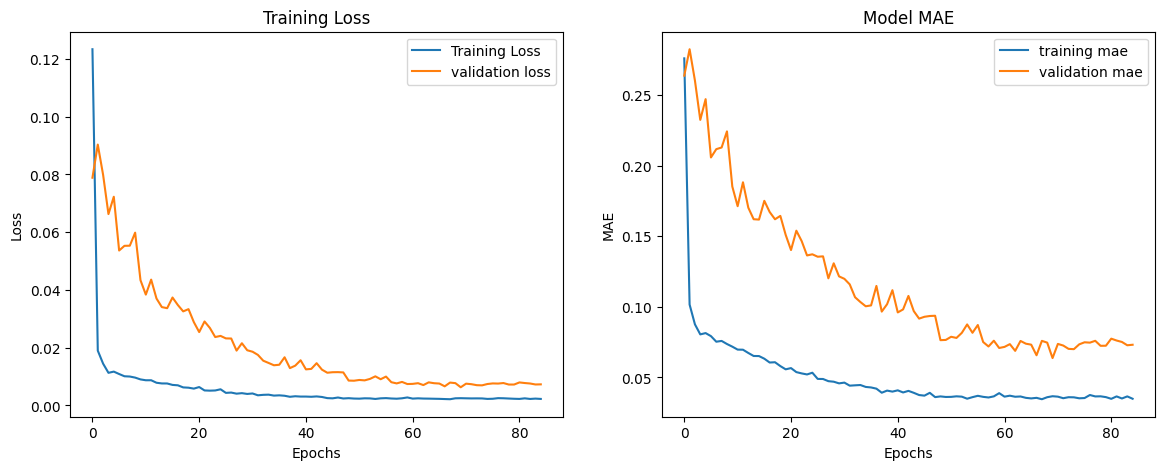

In [37]:
model = model_train(model, callbacks, X_train, y_train, X_test, y_test, epochs = 100, batch_size=32)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Mean squared error: 20356.6125
Root Mean Squared Error: 142.6766
Mean Absolute Error: 114.6240
r2 Score: 0.7346


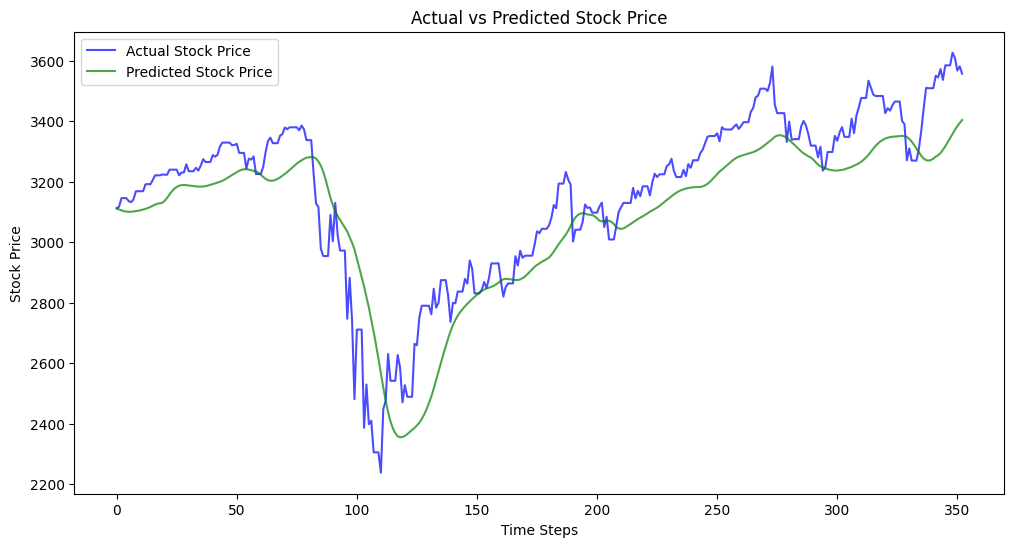

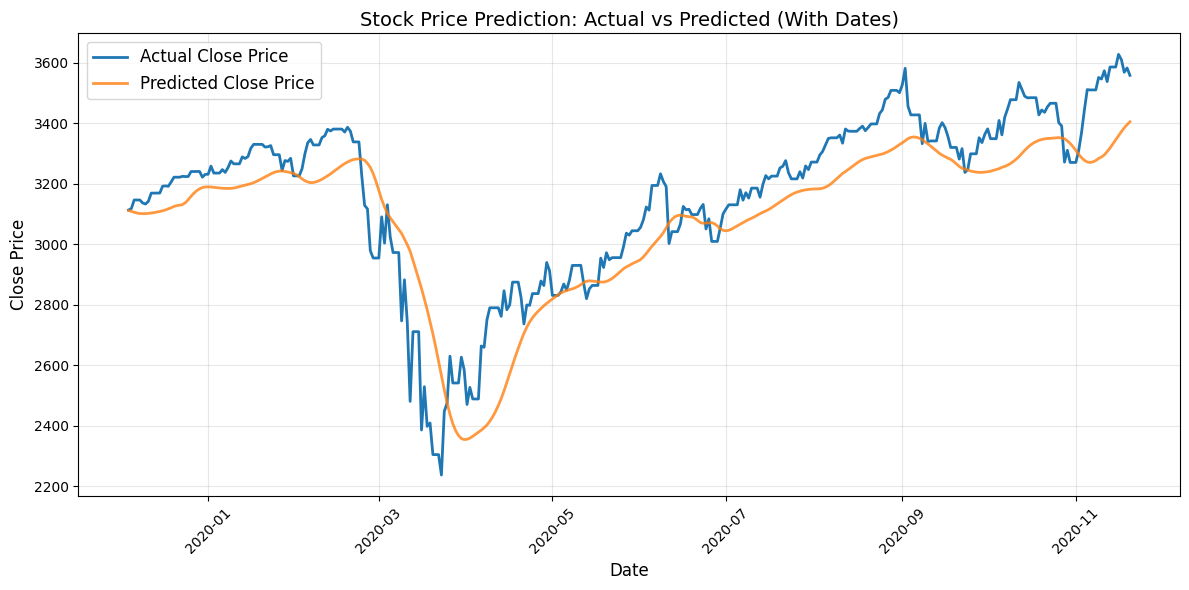

In [40]:
model_eval(model, stocks_df, train_size, 60, X_test, y_test, scaler, target_idx=5)